In [1]:
import pandas as pd
path = "/Users/avani/Desktop/MobileWell400/"

for f in ["daily_survey.csv", "noise.csv", "connectivity.csv", "activity_recognition.csv"]:
    df = pd.read_csv(path + f, nrows=2)
    print(f"\n{f} columns:\n", list(df.columns))



daily_survey.csv columns:
 ['participant', 'timestamp', 'valence', 'energetic_arousal', 'tense_arousal', 'emotional_event', 'social_quantity', 'social_quality', 'occasion', 'survey_start_timestamp', 'survey_end_timestamp', 'affect_and_emotional_event_questionnaire_start_timestamp', 'valence_answer_timestamp', 'energetic_arousal_answer_timestamp', 'tense_arousal_answer_timestamp', 'emotional_event_answer_timestamp', 'social_interaction_questionnaire_start_timestamp', 'social_quantity_answer_timestamp', 'social_quality_answer_timestamp', 'timestamp_UTC']

noise.csv columns:
 ['participant', 'timestamp', 'max_decibel', 'min_decibel', 'std_decibel', 'mean_decibel', 'num_samples', 'timestamp_UTC']

connectivity.csv columns:
 ['participant', 'timestamp', 'connectivity_status', 'timestamp_UTC']

activity_recognition.csv columns:
 ['participant', 'timestamp', 'label', 'confidence', 'timestamp_UTC']


In [2]:
import pandas as pd
import numpy as np
from mlxtend.frequent_patterns import apriori, fpgrowth, association_rules
from mlxtend.preprocessing import TransactionEncoder
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

path = "/Users/avani/Desktop/MobileWell400/"

In [3]:
survey = pd.read_csv(path + "daily_survey.csv", usecols=[
    "participant", "timestamp", "social_quantity", "social_quality", "valence", "tense_arousal"
])
noise = pd.read_csv(path + "noise.csv", usecols=[
    "participant", "timestamp", "mean_decibel"
])
conn = pd.read_csv(path + "connectivity.csv", usecols=[
    "participant", "timestamp", "connectivity_status"
])
activity = pd.read_csv(path + "activity_recognition.csv", usecols=[
    "participant", "timestamp", "label"
])

print("Files loaded successfully")
print("Survey shape:", survey.shape)
print("Noise shape:", noise.shape)
print("Connectivity shape:", conn.shape)
print("Activity shape:", activity.shape)


Files loaded successfully
Survey shape: (22563, 6)
Noise shape: (239798, 3)
Connectivity shape: (146059, 3)
Activity shape: (10045512, 3)


In [4]:
survey_sample = survey.sample(n=500, random_state=42)

# Keep only key and useful columns (drop duplicate timestamp names)
noise_small = noise.groupby("participant").head(1).rename(columns={"timestamp": "noise_time"})
conn_small = conn.groupby("participant").head(1).rename(columns={"timestamp": "conn_time"})
activity_small = activity.groupby("participant").head(1).rename(columns={"timestamp": "activity_time"})

# Merge safely
merged = survey_sample.merge(noise_small, on="participant", how="left") \
                      .merge(conn_small, on="participant", how="left") \
                      .merge(activity_small, on="participant", how="left")

# Drop missing key fields
merged = merged.dropna(subset=["social_quantity", "social_quality", "valence", "tense_arousal"])
print("Merged sample data:", merged.shape)

Merged sample data: (406, 12)


In [5]:
def categorize_noise(x):
    if x < 30: return "quiet"
    elif x < 60: return "moderate"
    else: return "loud"

merged["noise_level"] = merged["mean_decibel"].apply(categorize_noise)

In [6]:
cols = ["social_quantity", "social_quality", "valence", "tense_arousal",
        "connectivity_status", "label", "noise_level"]

transactions = merged[cols].astype(str).values.tolist()

te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df = pd.DataFrame(te_ary, columns=te.columns_)

print("Encoded transactions:", df.shape)

Encoded transactions: (406, 216)


In [7]:
rules_apriori = apriori(df, min_support=0.05, use_colnames=True)
rules_apriori = association_rules(rules_apriori, metric="lift", min_threshold=1.0)
rules_apriori = rules_apriori.sort_values("lift", ascending=False)
print("\nApriori (Top 5):")
print(rules_apriori.head())

rules_fp = fpgrowth(df, min_support=0.05, use_colnames=True)
rules_fp = association_rules(rules_fp, metric="lift", min_threshold=1.0)
rules_fp = rules_fp.sort_values("lift", ascending=False)
print("\nFP-Growth (Top 5):")
print(rules_fp.head())


Apriori (Top 5):
   antecedents consequents  antecedent support  consequent support   support  \
62         (0)  (50.0, 50)            0.086207            0.076355  0.051724   
59  (50.0, 50)         (0)            0.076355            0.086207  0.051724   
61      (50.0)     (0, 50)            0.123153            0.056650  0.051724   
60     (0, 50)      (50.0)            0.056650            0.123153  0.051724   
63        (50)   (50.0, 0)            0.133005            0.056650  0.051724   

    confidence      lift  leverage  conviction  zhangs_metric  
62    0.600000  7.858065  0.045142    2.309113       0.955076  
59    0.677419  7.858065  0.045142    2.832759       0.944889  
61    0.420000  7.413913  0.044748    1.626465       0.986624  
60    0.913043  7.413913  0.044748   10.083744       0.917071  
63    0.388889  6.864734  0.044189    1.543663       0.985390  

FP-Growth (Top 5):
    antecedents consequents  antecedent support  consequent support   support  \
164         (0) 

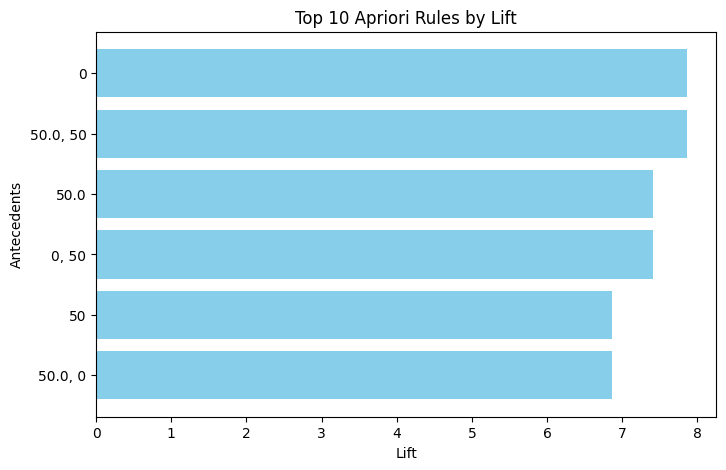

In [8]:
top_rules = rules_apriori.nlargest(10, "lift")
top_rules["antecedents"] = top_rules["antecedents"].apply(lambda x: ', '.join(list(x)))
plt.figure(figsize=(8, 5))
plt.barh(top_rules["antecedents"], top_rules["lift"], color="skyblue")
plt.xlabel("Lift")
plt.ylabel("Antecedents")
plt.title("Top 10 Apriori Rules by Lift")
plt.gca().invert_yaxis()
plt.show()


In [9]:

from mlxtend.frequent_patterns import apriori, association_rules

# Select key columns
cols = ["social_quantity", "social_quality", "valence", "tense_arousal", 
        "connectivity_status", "mean_decibel", "label"]

# Keep only relevant and clean rows
data_apriori = merged[cols].dropna()

# Discretize noise into categories (for better pattern detection)
def noise_category(x):
    if x < 40:
        return "quiet"
    elif x < 70:
        return "moderate"
    else:
        return "loud"

data_apriori["noise_level"] = data_apriori["mean_decibel"].apply(noise_category)
data_apriori = data_apriori.drop(columns=["mean_decibel"])

# Convert all columns to string (Apriori needs categorical data)
data_apriori = data_apriori.astype(str)

print("Data prepared for Apriori:", data_apriori.shape)
data_apriori.head()


Data prepared for Apriori: (359, 7)


,social_quantity,social_quality,valence,tense_arousal,connectivity_status,label,noise_level
0,2 persons,20.0,17,19,wifi,TILTING,moderate
1,2 persons,-25.0,-35,86,none,STILL,moderate
2,3-5 persons,46.0,48,30,none,STILL,quiet
3,5+ persons,19.0,12,44,wifi,STILL,moderate
4,5+ persons,-9.0,-6,20,none,TILTING,quiet


In [10]:
from mlxtend.preprocessing import TransactionEncoder

# Convert rows to transactions (list of items per row)
transactions = data_apriori.apply(lambda x: [f"{col}={val}" for col, val in x.items()], axis=1)

te = TransactionEncoder()
te_data = te.fit(transactions).transform(transactions)
df_encoded = pd.DataFrame(te_data, columns=te.columns_)

# Find frequent itemsets
freq_items = apriori(df_encoded, min_support=0.05, use_colnames=True)

# Generate rules
rules_apriori = association_rules(freq_items, metric="lift", min_threshold=1.0)

# Sort by confidence
rules_apriori = rules_apriori.sort_values(by="confidence", ascending=False)

print("Apriori rules generated:", rules_apriori.shape)
rules_apriori.head(10)


Apriori rules generated: (216, 10)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
172,"(tense_arousal=0, valence=50)",(social_quality=50.0),0.058496,0.125348,0.052925,0.904762,7.217989,0.045592,9.183844,0.914980
178,"(social_quantity=5+ persons, label=TILTING, co...",(noise_level=moderate),0.058496,0.721448,0.052925,0.904762,1.254091,0.010723,2.924791,0.215198
173,"(tense_arousal=0, social_quality=50.0)",(valence=50),0.058496,0.125348,0.052925,0.904762,7.217989,0.045592,9.183844,0.914980
88,"(label=TILTING, connectivity_status=none)",(noise_level=moderate),0.161560,0.721448,0.139276,0.862069,1.194914,0.022719,2.019499,0.194551
156,"(label=TILTING, social_quantity=2 persons)",(noise_level=moderate),0.075209,0.721448,0.064067,0.851852,1.180752,0.009807,1.880223,0.165532
194,"(connectivity_status=wifi, social_quantity=2 p...",(label=STILL),0.072423,0.571031,0.061281,0.846154,1.481801,0.019925,2.788301,0.350532
121,"(connectivity_status=wifi, social_quantity=2 p...",(label=STILL),0.091922,0.571031,0.075209,0.818182,1.432816,0.022719,2.359331,0.332652
207,"(connectivity_status=wifi, noise_level=moderat...",(label=STILL),0.061281,0.571031,0.050139,0.818182,1.432816,0.015146,2.359331,0.321794
192,"(connectivity_status=wifi, label=STILL, social...",(noise_level=moderate),0.075209,0.721448,0.061281,0.814815,1.129415,0.007022,1.504178,0.123905
150,"(label=STILL, social_quantity=3-5 persons)",(noise_level=moderate),0.147632,0.721448,0.119777,0.811321,1.124572,0.013268,1.476323,0.129959


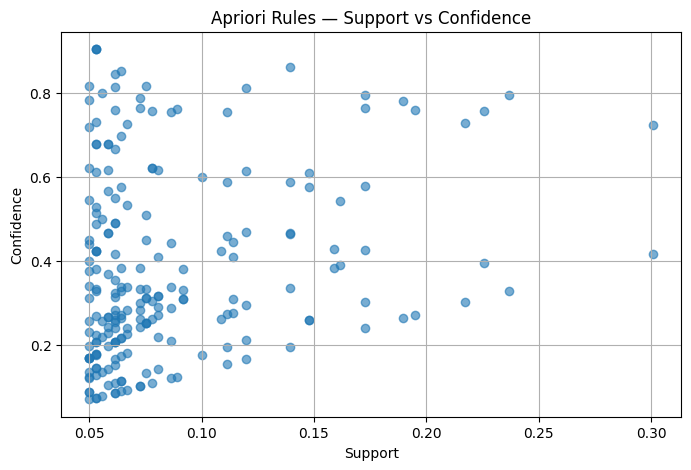

,antecedents,consequents,support,confidence,lift
172,"(tense_arousal=0, valence=50)",(social_quality=50.0),0.052925,0.904762,7.217989
178,"(social_quantity=5+ persons, label=TILTING, co...",(noise_level=moderate),0.052925,0.904762,1.254091
173,"(tense_arousal=0, social_quality=50.0)",(valence=50),0.052925,0.904762,7.217989
88,"(label=TILTING, connectivity_status=none)",(noise_level=moderate),0.139276,0.862069,1.194914
156,"(label=TILTING, social_quantity=2 persons)",(noise_level=moderate),0.064067,0.851852,1.180752
194,"(connectivity_status=wifi, social_quantity=2 p...",(label=STILL),0.061281,0.846154,1.481801
121,"(connectivity_status=wifi, social_quantity=2 p...",(label=STILL),0.075209,0.818182,1.432816
207,"(connectivity_status=wifi, noise_level=moderat...",(label=STILL),0.050139,0.818182,1.432816
192,"(connectivity_status=wifi, label=STILL, social...",(noise_level=moderate),0.061281,0.814815,1.129415
150,"(label=STILL, social_quantity=3-5 persons)",(noise_level=moderate),0.119777,0.811321,1.124572


In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.scatter(rules_apriori['support'], rules_apriori['confidence'], alpha=0.6)
plt.title("Apriori Rules — Support vs Confidence")
plt.xlabel("Support")
plt.ylabel("Confidence")
plt.grid(True)
plt.show()

# Display strongest social-behavior → mood relationships
rules_apriori[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10)


In [12]:
social_terms = ["social_quantity", "social_quality", "connectivity_status", "noise_level", "label"]
mood_terms = ["valence", "tense_arousal"]

# Keep only rules where antecedents contain social features
# and consequents contain mood features
def is_social_to_mood(rule):
    antecedent_str = " ".join(list(rule['antecedents']))
    consequent_str = " ".join(list(rule['consequents']))
    return any(s in antecedent_str for s in social_terms) and any(m in consequent_str for m in mood_terms)

rules_focus = rules_apriori[rules_apriori.apply(is_social_to_mood, axis=1)]

# Sort by confidence to show strongest associations
rules_focus = rules_focus.sort_values(by="confidence", ascending=False)

print("Filtered rules (social → mood):", rules_focus.shape)
rules_focus[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10)


Filtered rules (social → mood): (7, 10)


,antecedents,consequents,support,confidence,lift
173,"(tense_arousal=0, social_quality=50.0)",(valence=50),0.052925,0.904762,7.217989
174,"(valence=50, social_quality=50.0)",(tense_arousal=0),0.052925,0.678571,7.858295
61,(social_quality=50.0),(valence=50),0.077994,0.622222,4.963951
59,(social_quality=50.0),(tense_arousal=0),0.058496,0.466667,5.404301
177,(social_quality=50.0),"(tense_arousal=0, valence=50)",0.052925,0.422222,7.217989
44,(label=TILTING),(valence=50),0.061281,0.205607,1.640291
62,(social_quantity=5+ persons),(valence=50),0.061281,0.165414,1.319632


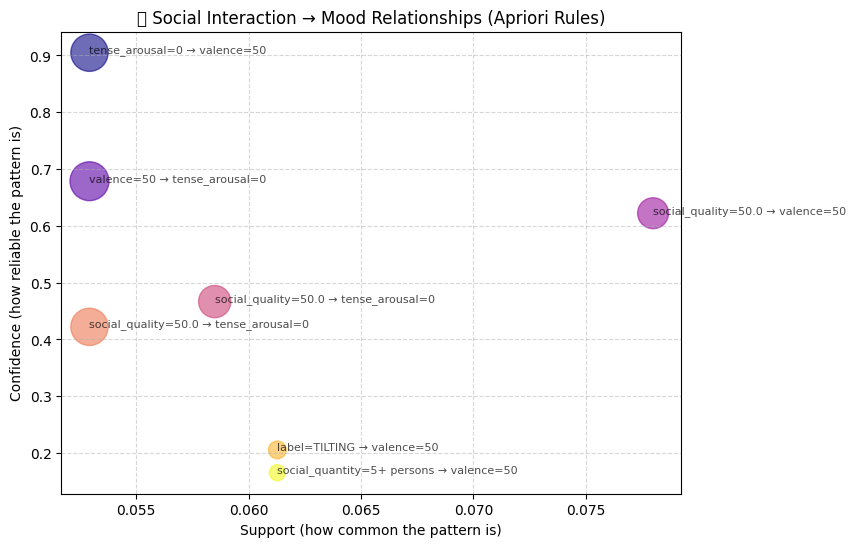

In [13]:
import matplotlib.pyplot as plt
df_rules = rules_focus.copy()

plt.figure(figsize=(8, 6))
plt.scatter(
    df_rules["support"],
    df_rules["confidence"],
    s=df_rules["lift"] * 100,  # bubble size = strength of relationship
    alpha=0.6,
    c=range(len(df_rules)), cmap="plasma"
)

# Add labels for the top few rules
for i, txt in enumerate(df_rules.head(7).index):
    antecedent = list(df_rules["antecedents"].iloc[i])[0]
    consequent = list(df_rules["consequents"].iloc[i])[0]
    plt.annotate(f"{antecedent} → {consequent}",
                 (df_rules["support"].iloc[i], df_rules["confidence"].iloc[i]),
                 fontsize=8, alpha=0.7)

plt.title("💬 Social Interaction → Mood Relationships (Apriori Rules)")
plt.xlabel("Support (how common the pattern is)")
plt.ylabel("Confidence (how reliable the pattern is)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()
